<a href="https://colab.research.google.com/github/NFalah25/ML-Naufal3A/blob/main/Modul-10/Praktikum_Tugas_Pertemuan_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nama : Naufal Falah Wafiuddin
# Kelas : TI - 3A
# Absen : 23
# NIM : 2141720129

## Praktikum 1

RNN untuk Analisis Sentimen

### Setup

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+metric], '')
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend([metric, 'val_'+metric])

### Setup Input Pipline

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2023-11-05 14:28:13.461274: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"OK, it was a good American Pie. Erick Stifler goes off to college with his buddy Cooze. During their arrival they meet up with Eric's cousin Dwight. The two pledge to become Betas and along the way they get involved with a whole lot of sex, tits, and some hot girls along the way. In a few words there is a lot more sex, nudity and alcohol. It is a good movie for those who want to enjoy an American Pie movie, granted it isn't as great as the first three is is a good movie. If you enjoy hot girls with really nice tits, get this movie. If you enjoy seeing a bunch of dudes making assholes of themselves, go to this movie. If you want to see the full thing, get the unrated addition. One last thing this is a better attempt than the last two American Pies."
 b"I saw this movie at the 18th Haifa film festival, and it is one of the best I've seen this year. Seeing it on a big screen (and I mean BIG, not one of those TV screens most cinemas have) with an excellent sound system always en

2023-11-05 14:28:14.152507: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Buat Teks Encoder

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[597,   9,  14, ...,   0,   0,   0],
       [ 10, 208,  11, ...,   0,   0,   0],
       [ 49,  34, 441, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"OK, it was a good American Pie. Erick Stifler goes off to college with his buddy Cooze. During their arrival they meet up with Eric's cousin Dwight. The two pledge to become Betas and along the way they get involved with a whole lot of sex, tits, and some hot girls along the way. In a few words there is a lot more sex, nudity and alcohol. It is a good movie for those who want to enjoy an American Pie movie, granted it isn't as great as the first three is is a good movie. If you enjoy hot girls with really nice tits, get this movie. If you enjoy seeing a bunch of dudes making assholes of themselves, go to this movie. If you want to see the full thing, get the unrated addition. One last thing this is a better attempt than the last two American Pies."
Round-trip:  ok it was a good american [UNK] [UNK] [UNK] goes off to [UNK] with his [UNK] [UNK] during their [UNK] they meet up with [UNK] [UNK] [UNK] the two [UNK] to become [UNK] and along the way they get involved with a whol

### Buat Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 5s 5s/step
[-0.01358242]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 197ms/step
[-0.01358242]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


2023-11-05 14:28:39.591680: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_40/output/_23'


391/391 [==============================] - 106s 237ms/step - loss: 0.6305 - accuracy: 0.5850 - val_loss: 0.4748 - val_accuracy: 0.7880
Epoch 2/10


2023-11-05 14:30:14.869380: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 77s 197ms/step - loss: 0.3975 - accuracy: 0.8187 - val_loss: 0.3626 - val_accuracy: 0.8313
Epoch 3/10


2023-11-05 14:31:32.060761: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 78s 199ms/step - loss: 0.3373 - accuracy: 0.8520 - val_loss: 0.3378 - val_accuracy: 0.8552
Epoch 4/10


2023-11-05 14:32:50.008862: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 78s 198ms/step - loss: 0.3220 - accuracy: 0.8602 - val_loss: 0.3417 - val_accuracy: 0.8484
Epoch 5/10


2023-11-05 14:34:07.553508: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 74s 189ms/step - loss: 0.3130 - accuracy: 0.8654 - val_loss: 0.3306 - val_accuracy: 0.8594
Epoch 6/10


2023-11-05 14:35:21.758701: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 74s 189ms/step - loss: 0.3073 - accuracy: 0.8681 - val_loss: 0.3279 - val_accuracy: 0.8490
Epoch 7/10


2023-11-05 14:36:35.921427: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 75s 190ms/step - loss: 0.3051 - accuracy: 0.8678 - val_loss: 0.3277 - val_accuracy: 0.8573
Epoch 8/10


2023-11-05 14:37:50.647138: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 75s 190ms/step - loss: 0.3027 - accuracy: 0.8709 - val_loss: 0.3270 - val_accuracy: 0.8490
Epoch 9/10


2023-11-05 14:39:05.284833: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 156s 398ms/step - loss: 0.3003 - accuracy: 0.8696 - val_loss: 0.3344 - val_accuracy: 0.8411
Epoch 10/10


2023-11-05 14:41:40.895640: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 233s 595ms/step - loss: 0.3014 - accuracy: 0.8704 - val_loss: 0.3226 - val_accuracy: 0.8547


2023-11-05 14:45:33.994295: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 83s 213ms/step - loss: 0.3165 - accuracy: 0.8582
Test Loss: 0.31654608249664307
Test Accuracy: 0.8581600189208984


(0.0, 0.6469558849930763)

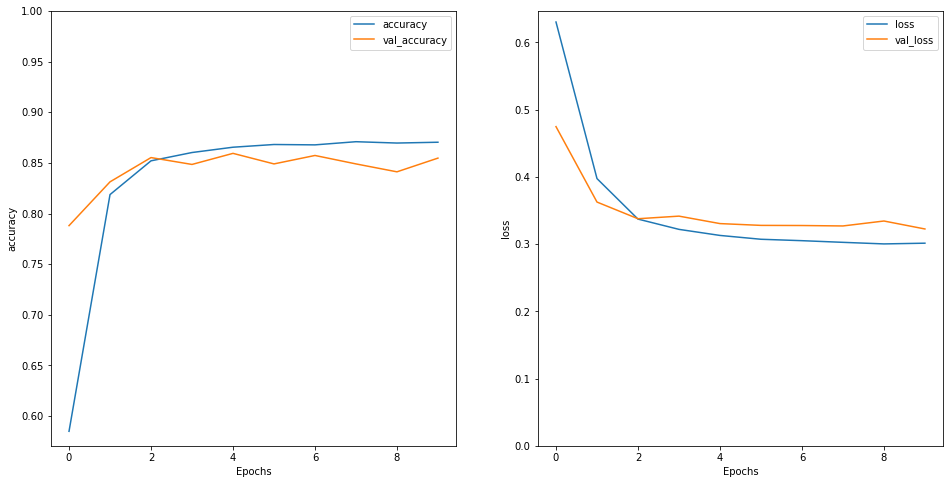

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.92014045]


### Stack Two or More LSTM Layers

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional

In [ ]:
model = tf.keras.Sequential([encoder,
                             tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(units=64, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1)
])


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10


391/391 [==============================] - 232s 556ms/step - loss: 0.6395 - accuracy: 0.5526 - val_loss: 0.4629 - val_accuracy: 0.7979
Epoch 2/10
391/391 [==============================] - 145s 371ms/step - loss: 0.4226 - accuracy: 0.8136 - val_loss: 0.3781 - val_accuracy: 0.8313
Epoch 3/10
391/391 [==============================] - 139s 355ms/step - loss: 0.3671 - accuracy: 0.8428 - val_loss: 0.3484 - val_accuracy: 0.8495
Epoch 4/10
391/391 [==============================] - 136s 347ms/step - loss: 0.3506 - accuracy: 0.8490 - val_loss: 0.3994 - val_accuracy: 0.8135
Epoch 5/10
391/391 [==============================] - 142s 363ms/step - loss: 0.3319 - accuracy: 0.8580 - val_loss: 0.3279 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 139s 354ms/step - loss: 0.3166 - accuracy: 0.8667 - val_loss: 0.3223 - val_accuracy: 0.8620
Epoch 7/10
391/391 [==============================] - 140s 358ms/step - loss: 0.3126 - accuracy: 0.8694 - val_loss: 0.3184 - val_accura

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 42s 108ms/step - loss: 0.3346 - accuracy: 0.8622
Test Loss: 0.3345785140991211
Test Accuracy: 0.8621600270271301


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-1.9061744]]


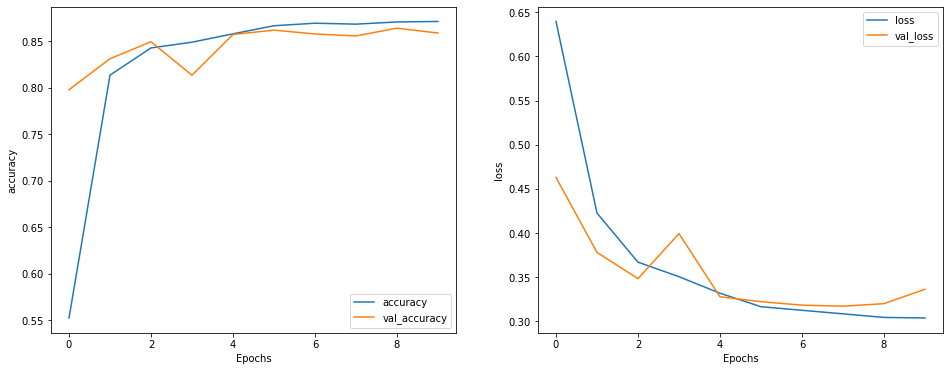

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2

## Setup

### Import TensorFlow

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

### Load Data

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Olah Teks

### Vektorize Teks

In [ ]:
example_texts = ['abcdefg','xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
        vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary = ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
        return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### Pediksi

#### Membuat Training Set dan Target

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
        input_text = sequence[:-1]
        target_text = sequence[1:]
        return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
        print("Input :", text_from_ids(input_example).numpy())
        print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


#### Membuat Batch Training

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

### Buat Model

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size = vocab_size,
    embedding_dim = embedding_dim,
    rnn_units = rnn_units)

### Uji Model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
        example_batch_predictions = model(input_example_batch)
        print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  16896     
                                                                 
 gru_2 (GRU)                 multiple                  3938304   
                                                                 
 dense_6 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([ 8, 63, 12, 42, 63, 17, 47, 11, 37, 63,  6, 35, 23, 19, 53,  5,  4,
       54, 28,  9, 52,  8, 54, 32, 21, 16, 31, 44, 17, 61,  7,  1, 29, 47,
       39, 40, 63,  2, 11,  9, 33, 63, 27, 40, 15, 48, 58, 28, 34, 48,  9,
       55, 47,  6, 63, 10,  5,  7, 48, 46, 42, 45, 24, 19, 46, 33, 38, 61,
       48, 58, 62, 23,  5, 46, 62, 64, 48, 54, 15,  9, 37, 24, 61, 15, 62,
       54,  2, 55, 63, 10, 45, 20, 40, 62, 20, 31, 39, 16,  7, 14])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'iction has a taste as sweet\nAs any cordial comfort. Still, methinks,\nThere is an air comes from her:'

Next Char Predictions:
 b"-x;cxDh:Xx'VJFn&$oO.m-oSHCReDv,\nPhZax :.TxNaBisOUi.ph'x3&,igcfKFgTYviswJ&gwyioB.XKvBwo px3fGawGRZC,A"


### Train Model

Tambahkan optimizer dan fungsi loss

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1917105, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.13581

In [ ]:
model.compile(optimizer='adam', loss=loss)

#### Konfigurasi Checkpoints

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

#### Lakukan Proses Training

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20


172/172 [==============================] - 248s 1s/step - loss: 2.7360
Epoch 2/20
172/172 [==============================] - 249s 1s/step - loss: 1.9969
Epoch 3/20
172/172 [==============================] - 248s 1s/step - loss: 1.7219
Epoch 4/20
172/172 [==============================] - 248s 1s/step - loss: 1.5614
Epoch 5/20
172/172 [==============================] - 248s 1s/step - loss: 1.4606
Epoch 6/20
172/172 [==============================] - 248s 1s/step - loss: 1.3922
Epoch 7/20
172/172 [==============================] - 247s 1s/step - loss: 1.3388
Epoch 8/20
172/172 [==============================] - 248s 1s/step - loss: 1.2958
Epoch 9/20
172/172 [==============================] - 248s 1s/step - loss: 1.2550
Epoch 10/20
172/172 [==============================] - 270s 2s/step - loss: 1.2157
Epoch 11/20
172/172 [==============================] - 277s 2s/step - loss: 1.1763
Epoch 12/20
172/172 [==============================] - 268s 2s/step - loss: 1.1376
Epoch 13/20
172/172 [===

### Generate Text

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Yet for this news, the heaveness burn and lands and grace.
But love thee speak fair-roal to the truth;
And here I ripening further,
Till how I do throw down not only face?
Supper-a-soul and desortue of your good
worst in beauty, and been ballad.

POLIXENES:
Veruly, I beseech you, ladies. All this night's cartain,
Yet hath no that hath brought his sword, and may not bring
him adonery; yet, to pluck from thee, three?

SEBASTIAN:
'Twas he express my horses, and about my commonable.

KING EDWARD IV:
Glab some unboan's life seen, towards killent Kate,
To better other, as I said it.

First Citizen:
Say you to't?

PORIXE:
I would I take thy lowel school.

PERDITA:
Sir, that I stood to thy hast sees in this
favourity,
Which for robbers unstubstanty of no reys forsworn;
For whose sudard bare and age to our night,
But in the vessess 'scaped up with chin herself:
Before the king yourself in perford.

LUCENTIO:
A little, heard-me not.
What was your grace uphis?' keep your grace!

DUKE VINCE

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nGood morrow, noble lord; and he that has her ignorant could sheep\nTill I losg and be his fignithen now.\n\nFirst Murderer:\nO God's name, sweet Kate!\n\nANGELO:\nHe's a little while. Lamber!\nI will to Rome, cubble things,\nLike an applext of the bowels\nAnd give with usurping vasitions young\nMistress new your visage instantly.\n\nLord Mayor:\n'Tis bushing her: there is not danger.\n\nKING HENRY VI:\nMadam, have some hours he entreat you.\n\nVINCENTIO:\nSay that the court-hold Richard hath a thirt\nYour divine hope she should show my husband.\n\nBAPTISTA:\nSaw, I am sorry that the postern of my poor Mark'd\nBy holy word, with this deceive them of your honour,\nAnd leave thy death; evercy word this peace!\nAh, Jeaul! chance me to the bree-heaven's blood,\nHer fatherly committed hastens.\n\nVOLUMNIA:\nAs an one sire, I'll go this home.\n\nFirst Murderer:\nTake the service. Come, I'll be new-get in my mouth.\n\nROMEO:\nNailord's lord?\nI came to ten your royal grou

### Ekspor Model Generator

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

INFO:tensorflow:Assets written to: one_step/assets


INFO:tensorflow:Assets written to: one_step/assets


In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
A little hour his lips across chafes, and true.

DORPES:
Your pity is yours with his father's force


## Tugas Praktikum

Gunakan tf.GradientTape untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca eager execution guide.
Prosedurnya adalah :
1. Jalankan Model dan hitung loss dengan tf.GradientTape.
2. Hitung update dan terapkan pada model dengan optimizer

In [ ]:
class CustomTraining(MyModel):
        @tf.function
        def train_step(self, inputs):
                inputs, labels = inputs
                with tf.GradientTape() as tape:
                        predictions = self(inputs, training=True)
                        loss = self.loss(labels, predictions)
                grads = tape.gradient(loss, model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, model.trainable_variables))
                return {'loss': loss}

In [ ]:
model = CustomTraining(
        vocab_size=len(ids_from_chars.get_vocabulary()),
        embedding_dim=embedding_dim,
        rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 260s 1s/step - loss: 2.7377


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
        start = time.time()

        mean.reset_states()
        for (batch_n, (inp, target)) in enumerate(dataset):
                logs = model.train_step([inp, target])
                mean.update_state(logs['loss'])

                if batch_n % 50 == 0:
                        template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
                        print(template)
# saving (checkpoint) the model every 5 epochs
        if (epoch + 1) % 5 == 0:
                model.save_weights(checkpoint_prefix.format(epoch=epoch))

        print()
        print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
        print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
        print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1874
Epoch 1 Batch 50 Loss 2.0520
Epoch 1 Batch 100 Loss 1.9436
Epoch 1 Batch 150 Loss 1.8370

Epoch 1 Loss: 2.0003
Time taken for 1 epoch 307.76 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8212
Epoch 2 Batch 50 Loss 1.7710
Epoch 2 Batch 100 Loss 1.7348
Epoch 2 Batch 150 Loss 1.6757

Epoch 2 Loss: 1.7168
Time taken for 1 epoch 314.27 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6129
Epoch 3 Batch 50 Loss 1.5669
Epoch 3 Batch 100 Loss 1.5553
Epoch 3 Batch 150 Loss 1.5135

Epoch 3 Loss: 1.5534
Time taken for 1 epoch 186.16 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4799
Epoch 4 Batch 50 Loss 1.4872
Epoch 4 Batch 100 Loss 1.4182
Epoch 4 Batch 150 Loss 1.4431

Epoch 4 Loss: 1.4529
Time taken for 1 epoch 150.15 sec
_________________________________________________________________

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?
> Perbedaan kode diatas dengan praktikum 2 yaitu pada praktikum 2 tidak memberi kita banyak kendali atas pelatihan. praktikum 2 menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan.